In [3]:
%pip install darts
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


In [4]:
## Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import mean_absolute_error
from pytorch_lightning.callbacks import ModelCheckpoint
import optuna
from tqdm import tqdm


In [5]:
## Read data
data = pd.read_parquet(r"..\01_Datenaufbereitung\Output\Calculated\df_15.parquet")
data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
data = data[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Current[A]', 'Voltage[V]', 'Temperature[°C]', 'SOH_ZHU']]

## Resample to hourly
data.set_index('Absolute_Time[yyyy-mm-dd hh:mm:ss]', inplace=True)
data_hourly = data.resample('h').mean().reset_index()

## Fill missing values
data_hourly.interpolate(method='linear', inplace=True)
data_hourly['SOH_ZHU'] = data_hourly['SOH_ZHU'].fillna(1)

Text(0.5, 0, 'Time')

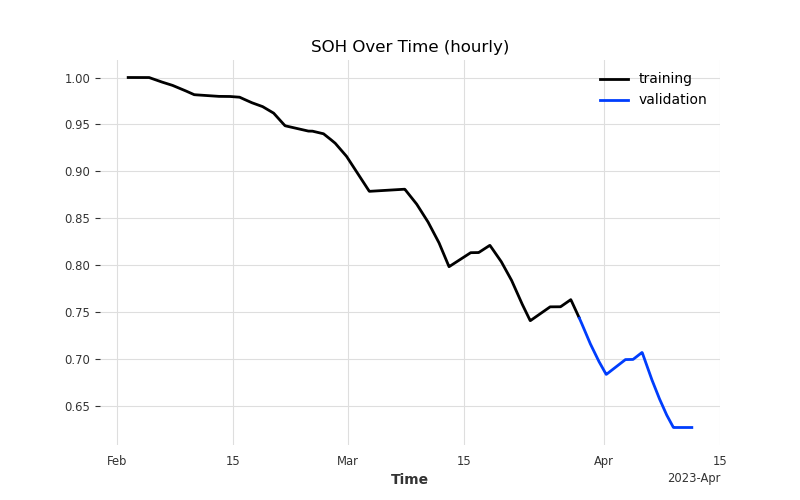

In [6]:
## Data to time series
target_series = TimeSeries.from_dataframe(data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU')
covariates = TimeSeries.from_dataframe(data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', ['Current[A]', 'Voltage[V]', 'Temperature[°C]'])

## Time align
target_series, covariates = target_series.slice_intersect(covariates), covariates.slice_intersect(target_series)

## Covariates normalization
scaler = Scaler() # Scale data [min,max] to [0,1]
## Don't scale SOH
covariates_scaled = scaler.fit_transform(covariates)

## Data split
train_series, val_series = target_series.split_after(0.8)
cov_train, cov_val = covariates_scaled.split_after(0.8)

# Time align
required_start_time = train_series.start_time() - pd.Timedelta(hours=12) 
if cov_train.start_time() > required_start_time:
    cov_train = covariates_scaled.slice(required_start_time, cov_train.end_time())
if cov_val.start_time() > required_start_time:
    cov_val = covariates_scaled.slice(required_start_time, cov_val.end_time())

plt.figure(figsize=(8, 5))
train_series.plot(label="training")
val_series.plot(label="validation")
plt.title("SOH Over Time (hourly)")
plt.xlabel("Time")

In [ ]:
# Optuna objective function
def objective(trial):
    # Define hyperparameter search space
    input_chunk_length = trial.suggest_int("input_chunk_length", 12, 24)
    output_chunk_length = trial.suggest_int("output_chunk_length", 1, 12)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    num_blocks = trial.suggest_int("num_blocks", 2, 3)
    num_stacks = trial.suggest_int("num_stacks", 2, 3)

    # Define and train model
    model = NBEATSModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        batch_size=batch_size,
        num_blocks=num_blocks,
        num_stacks=num_stacks,
        random_state=42,
        pl_trainer_kwargs={
            "callbacks": [ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)],
            "enable_checkpointing": True
        }
    )

    model.fit(series=train_series, past_covariates=cov_train, 
              val_series=val_series, val_past_covariates=cov_val, epochs=100)  
    
    # Retrieve best validation loss directly from the training process
    best_val_loss = model.trainer.checkpoint_callback.best_model_score.item() 
    
    return best_val_loss



In [ ]:
# Optuna call with progress bar
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  

# Best trial
print("Best trial:")
trial = study.best_trial
print(f"  Value (MAE): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [10]:
best_params = {'input_chunk_length': 15, 'output_chunk_length': 1, 'batch_size': 16, 'num_blocks': 2, 'num_stacks': 2}

In [11]:
# best_params = trial.params
best_model = NBEATSModel(
    input_chunk_length=best_params["input_chunk_length"],
    output_chunk_length=best_params["output_chunk_length"],
    batch_size=best_params["batch_size"],
    num_blocks=best_params["num_blocks"],
    num_stacks=best_params["num_stacks"],
    random_state=42,
    save_checkpoints=True
)

best_model.fit(series=train_series, past_covariates=cov_train, 
               val_series=val_series, val_past_covariates=cov_val, epochs=200, verbose=True)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 863 K  | train
-------------------------------------------------------------
862 K     Trainable params
1.6 K     Non-trainable params
863 K     Total params
3.455     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=2, num_blocks=2, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=15, output_chunk_length=1, batch_size=16, random_state=42, save_checkpoints=True)

c:\Users\zzhuqshun\.conda\envs\ML\lib\site-packages\darts\models\forecasting\torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForec

Predicting: |          | 0/? [00:00<?, ?it/s]

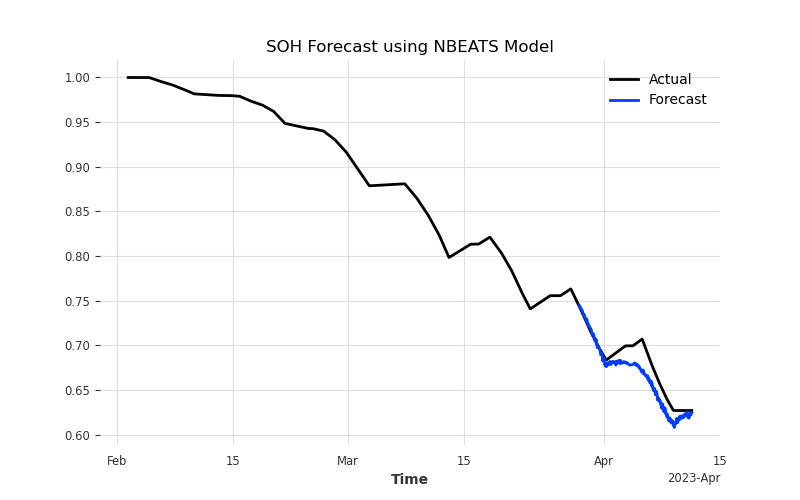

In [13]:
model = NBEATSModel.load_from_checkpoint('in22_out1_bs16_nb3_ns2')

pred_series = model.predict(len(val_series), series=train_series, past_covariates=cov_val)

plt.figure(figsize=(8, 5))
target_series.plot(label="Actual")
pred_series.plot(label="Forecast")
plt.title("SOH Forecast using NBEATS Model")
plt.xlabel("Time")
plt.legend()
plt.show()

# plt.figure(figsize=(8, 5)) 
# train_series.plot(label="train")
# val_series.plot(label="true")
# pred_series.plot(label="forecast")
# plt.legend()
# plt.xlabel('Time')
# plt.show()

In [ ]:
# param_grid = {
#     'input_chunk_length': [12, 24], # Half day or full day
#     'output_chunk_length': [1, 3, 6, 12], # One Hour or more
#     'batch_size': [16, 32, 64], # Training speed
#     'num_blocks': [2, 3], # Depth and nonliniarity
#     'num_stacks': [2, 3] # Different nonlinear mode 
# }

In [ ]:
# def grid_search_nbeats(param_grid, train_series, val_series, cov_train=None, cov_val=None):
#     best_params = None
#     best_score = float("inf")
#     best_model = None 

#     keys, values = zip(*param_grid.items())
#     param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

#     for params in tqdm(param_combinations, desc="Grid Search Progress"):
#         model = NBEATSModel(
#             input_chunk_length=params['input_chunk_length'],
#             output_chunk_length=params['output_chunk_length'],
#             batch_size=params['batch_size'],
#             num_blocks=params['num_blocks'],
#             num_stacks=params['num_stacks'],
#             random_state=42
#         )

#         # Training
#         model.fit(series=train_series, past_covariates=cov_train, epochs=200)

#         # Predict
#         pred_series = model.predict(len(val_series), series=train_series, past_covariates=cov_val)
#         score = mean_absolute_error(val_series.values(), pred_series.values())

#         print(f"Params: {params} - MAE: {score}")

#         if score < best_score:
#             best_score = score
#             best_params = params
#             best_model = model
#     if best_model is not None:
#         best_model.save_model("best_nbeats_model.pth")
#         print("Best model saved as 'best_nbeats_model.pth'")
        
#     print(f"Best Params: {best_params} with MAE: {best_score}")
#     return best_params, best_score

# best_params, best_score = grid_search_nbeats(param_grid, train_series, val_series, cov_train=cov_train, cov_val=cov_val)
